<a href="https://colab.research.google.com/github/j-thapaliya/NLP/blob/main/Encoder_BERT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install evaluate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 8.1 MB/s eta 0:00:00


In [2]:
#Most pretrained models of huggingface can be found in transformers - AutoModelForSequenceClassification (for us), AutoModel (general)
from datasets import load_dataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer

import numpy as np
import evaluate, random, time
import torch
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import pandas as pd

In [3]:
# Reproducibility and GPU
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(f"Using device: {device}")

Using device: cuda


In [4]:
#Loading AG News dataset from Huggingface
ds = load_dataset("ag_news")
train_texts, train_labels = ds["train"]["text"], ds["train"]["label"]
test_texts, test_labels   = ds["test"]["text"], ds["test"]["label"]
num_labels = len(set(train_labels))

print(f"AG News loaded → {len(train_texts)} train / {len(test_texts)} test / {num_labels} classes")

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

data/train-00000-of-00001.parquet:   0%|          | 0.00/18.6M [00:00<?, ?B/s]

data/test-00000-of-00001.parquet:   0%|          | 0.00/1.23M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/120000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/7600 [00:00<?, ? examples/s]

AG News loaded → 120000 train / 7600 test / 4 classes


In [5]:
print("\n Preparing dataset for BERT...")

#Base refers to smaller Bert model which uses 12 encoders and allows 512 word inputs, uncased means casing doesn't matter
base_tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

#Truncation removes the words if they exceed context size for model (512 for Bert base)
#padding max_length adds and extends all sequences' length to 128 words
def preprocess(batch):
    return base_tokenizer(batch["text"], truncation=True, padding="max_length", max_length=128)

#batch tokenization will be used to tokenize whole dataset
tokenized_ds = ds.map(preprocess, batched=True)
tokenized_ds = tokenized_ds.rename_column("label", "labels")

#Convert the data format to Pytorch tensor and leave the tokenized input_ids, attention_mask and labels which is direct input for BERT
tokenized_ds.set_format("torch", columns=["input_ids", "attention_mask", "labels"])


 Preparing dataset for BERT...


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Map:   0%|          | 0/120000 [00:00<?, ? examples/s]

Map:   0%|          | 0/7600 [00:00<?, ? examples/s]

In [6]:
#Function that dynamically creates a new Trainer pipeline for any dataset and BERT models
def run_bert_experiment(model_name, tokenized_ds, num_labels, seed=42, epochs=2):
    print(f"\nFine-tuning {model_name}")
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=num_labels).to(device)

    metric_acc = evaluate.load("accuracy")
    metric_f1 = evaluate.load("f1")

    def compute_metrics(pred):
        labels = pred.label_ids
        preds = pred.predictions.argmax(-1)
        return {
            "accuracy": metric_acc.compute(predictions=preds, references=labels)["accuracy"],
            "f1_macro": metric_f1.compute(predictions=preds, references=labels, average="macro")["f1"]
        }

    args = TrainingArguments(
        output_dir=f"./bert_results/{model_name.replace('/', '_')}", #directory to save the model
        eval_strategy="epoch", #evaluate the model at the end of every epoch
        save_strategy="epoch", #save the model after every epoch
        learning_rate=2e-5, #Smaller since we are fine-tuning, otherwise will overfit easily
        per_device_train_batch_size=64,
        per_device_eval_batch_size=64, #Batch size of evaluation can be doubled since no gradients are calculated here
        num_train_epochs=epochs,
        weight_decay=0.01, #L2 regularization strength for better generalization
        logging_steps=200, #Logging the progress messages (loss, learning rate etc) every 200 steps
        seed=seed, #Seed for reproducibility
        fp16=torch.cuda.is_available(), #GPU if available
        report_to="none", #No need to log the data to huggingface's db for visualization etc
        load_best_model_at_end=True, #Load the best model
        metric_for_best_model="accuracy"
    )

    trainer = Trainer(
        model=model,
        args=args,
        train_dataset=tokenized_ds["train"],
        eval_dataset=tokenized_ds["test"],
        tokenizer=tokenizer,
        compute_metrics=compute_metrics,
    )

    #Save the training time for each model
    t0 = time.time()
    trainer.train()
    train_time = time.time() - t0

    results = trainer.evaluate()
    acc, f1 = results["eval_accuracy"], results["eval_f1_macro"]
    print(f"{model_name} done → Acc={acc:.4f}, F1={f1:.4f}, Time={train_time/60:.1f} min")

    # Define class labels (in the same order as label IDs)
    class_names = ['World', 'Sports', 'Business', 'Science']

    # Compute confusion matrix for report
    preds_output = trainer.predict(tokenized_ds["test"])
    preds = np.argmax(preds_output.predictions, axis=-1)

    cm = confusion_matrix(preds_output.label_ids, preds)

    # Display confusion matrix with class names
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    disp.plot(cmap='Blues', values_format='d')
    plt.title(f"Confusion Matrix - {model_name}")
    plt.xlabel("Predicted Classes")
    plt.ylabel("Actual Classes")
    plt.show()

    return {"Model": model_name, "Accuracy": acc, "F1_macro": f1, "Train_time_s": train_time}


Fine-tuning bert-base-uncased


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


/tmp/ipython-input-4199399928.py:35: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro
1,0.175400,0.169057,0.943289,0.943266
2,0.130200,0.162034,0.948026,0.948121
3,0.083700,0.188532,0.944605,0.944610
4,0.061400,0.205727,0.943553,0.943560


bert-base-uncased done → Acc=0.9480, F1=0.9481, Time=8.5 min


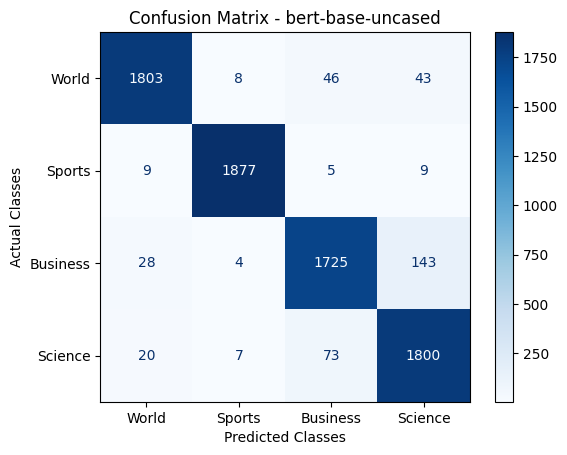


Fine-tuning distilbert-base-uncased


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-4199399928.py:35: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro
1,0.184000,0.174059,0.939211,0.939240
2,0.141200,0.167345,0.946053,0.946144
3,0.097900,0.173906,0.946447,0.946421
4,0.074900,0.182792,0.945658,0.945701


distilbert-base-uncased done → Acc=0.9464, F1=0.9464, Time=5.3 min


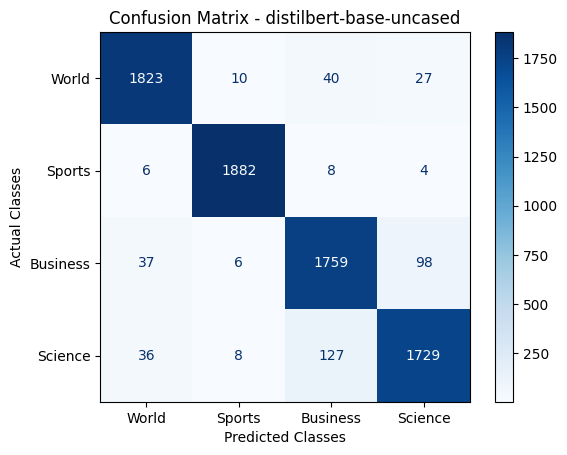

In [7]:
#Models used
bert_models = ["bert-base-uncased", "distilbert-base-uncased"]
bert_results = []

#Function call for fine-tuning the model
for m in bert_models:
    result = run_bert_experiment(m, tokenized_ds, num_labels, seed=seed, epochs=4)
    bert_results.append(result)

In [8]:
results_df = pd.DataFrame(bert_results)

print("\nFinal Comparison:")
display(results_df)


Final Comparison:


,Model,Accuracy,F1_macro,Train_time_s
0,bert-base-uncased,0.948026,0.948121,510.799089
1,distilbert-base-uncased,0.946447,0.946421,315.743780


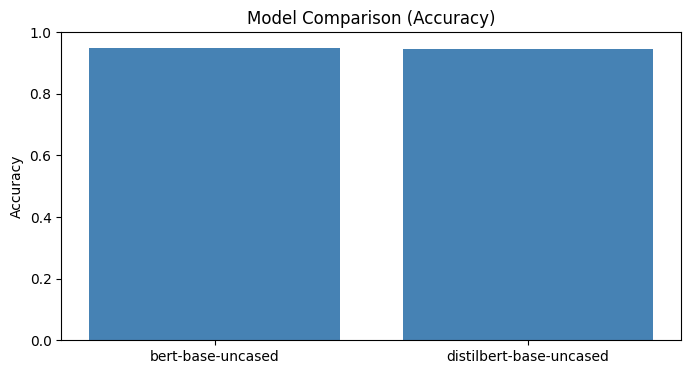

In [10]:
plt.figure(figsize=(8,4))
plt.bar(results_df["Model"], results_df["Accuracy"], color="steelblue")
plt.title("Model Comparison (Accuracy)")
plt.ylabel("Accuracy")
plt.ylim(0,1)
plt.show()